In [1]:
# Importing the packages needed for the model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import random
import warnings
import keras
# Importer les bibliothèques nécessaires
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential, Model
from tensorflow.keras.callbacks  import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, MultiHeadAttention, Flatten, Input, LayerNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split




warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('PJMW_hourly.csv', delimiter=',',  parse_dates=['Datetime'], index_col='Datetime')
data.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJMW_MW  143206 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [4]:
data.isnull().sum()

PJMW_MW    0
dtype: int64

In [5]:
data.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


In [6]:
scaler = MinMaxScaler()
data["PJMW_MW"] = scaler.fit_transform(data["PJMW_MW"].values.reshape(-1, 1)) 

In [7]:
# Définir la taille de la fenêtre temporelle
window_size = 24 # nombre de pas de temps à considérer pour la prévision
# Définir la taille de l'horizon de prévision
horizon = 6 # nombre de pas de temps à prédire
# Définir une fonction pour créer des séquences d'entrée et de sortie à partir des données
def create_sequences(data, window_size, horizon):
    X = [] # liste pour stocker les séquences d'entrée
    y = [] # liste pour stocker les séquences de sortie
    for i in range(window_size, len(data)  - horizon):
        X.append(data.iloc[i-window_size:i])
        y.append(data.iloc[i:i+horizon])
    # Convertir les listes en tableaux numpy
    X = np.array(X)
    y = np.array(y)
    return X, y

In [8]:
# Créer les séquences d'entrée et de sortie
X, y = create_sequences(data, window_size, horizon)

In [9]:
# séparer les données en données d'entrainement(80%) et de test(20%), n'oubliez pas de mettre en l'argument shuffle en False pour
# garder l'ordre chronologique de vos données.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=False)
# Afficher les dimensions des séquences
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (114540, 24, 1)
y_train shape: (114540, 6, 1)
X_test shape: (28636, 24, 1)
y_test shape: (28636, 6, 1)


#  Temporal Fusion Transformer : Prediction multi-horizon 6 hours

In [10]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.linear = Dense(units)
        self.sigmoid = Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)
    

class GatedResidualNetwork(keras.layers.Layer):
    def __init__(self, units, dropout_rate):
        super().__init__()
        self.units = units
        self.dropout_rate= dropout_rate
        self.elu_dense = Dense(units, activation="elu")
        self.linear_dense = Dense(units)
        self.dropout = Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = LayerNormalization()
        self.project = Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x

In [12]:
def create_tft_model(input_shape, units, dropout):
    # Input layer
    past_inputs = Input(shape=input_shape, name='past_inputs')
    
    # Static enrichment layers
    se = Dense(units, activation='relu')(past_inputs)
    se = Dense(units, activation='relu')(se)
    
    grn = GatedResidualNetwork(units, dropout)(se)
    
    # Temporal self-attention layers
    tsa = MultiHeadAttention(num_heads=16, key_dim=64)(grn, grn)
    
    # Position-wise feed-forward layers
    pff = Dense(units, activation='relu')(tsa)
    pff = Dense(units, activation='relu')(pff)
    
    # Temporal fusion decoder layers
    tfd = LSTM(units)(pff)
    
    tfd = Flatten()(tfd)
    
    # Output layer
    output = Dense(horizon)(tfd)
    
    model = Model(inputs=past_inputs, outputs=output)
    return model

In [13]:
# Création du modèle TFT
input_shape = (window_size, 1)
model = create_tft_model(input_shape, 64, 0.2)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 past_inputs (InputLayer)    [(None, 24, 1)]              0         []                            
                                                                                                  
 dense (Dense)               (None, 24, 64)               128       ['past_inputs[0][0]']         
                                                                                                  
 dense_1 (Dense)             (None, 24, 64)               4160      ['dense[0][0]']               
                                                                                                  
 gated_residual_network (Ga  (None, 24, 64)               16768     ['dense_1[0][0]']             
 tedResidualNetwork)                                                                          

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint("model_tft.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=60, verbose=1)]

model.compile(
    optimizer="adam",
    loss="mse",
)

epochs = 500
batch_size = 64

In [16]:
history = model.fit(
    X_train,y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1)

Epoch 1/500

1432/1432 [==============================] - 168s 108ms/step - loss: 0.0040 - val_loss: 0.0020 - lr: 0.0010
Epoch 2/500
1432/1432 [==============================] - 149s 104ms/step - loss: 0.0014 - val_loss: 0.0014 - lr: 0.0010
Epoch 3/500
1432/1432 [==============================] - 150s 105ms/step - loss: 0.0010 - val_loss: 0.0011 - lr: 0.0010
Epoch 4/500
1432/1432 [==============================] - 151s 105ms/step - loss: 8.4822e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 5/500
1432/1432 [==============================] - 151s 106ms/step - loss: 7.6194e-04 - val_loss: 9.8816e-04 - lr: 0.0010
Epoch 6/500
1432/1432 [==============================] - 121s 85ms/step - loss: 7.1346e-04 - val_loss: 9.6968e-04 - lr: 0.0010
Epoch 7/500
1432/1432 [==============================] - 96s 67ms/step - loss: 6.9004e-04 - val_loss: 8.7745e-04 - lr: 0.0010
Epoch 8/500
1432/1432 [==============================] - 87s 61ms/step - loss: 6.4747e-04 - val_loss: 9.8884e-04 - lr: 0.0010
Epoch 9/

1432/1432 [==============================] - 103s 72ms/step - loss: 3.6098e-04 - val_loss: 5.8668e-04 - lr: 5.0000e-04
Epoch 64/500
1432/1432 [==============================] - 167s 116ms/step - loss: 3.5906e-04 - val_loss: 6.2653e-04 - lr: 5.0000e-04
Epoch 65/500
1432/1432 [==============================] - 183s 128ms/step - loss: 3.5772e-04 - val_loss: 6.6646e-04 - lr: 5.0000e-04
Epoch 66/500
1432/1432 [==============================] - 176s 123ms/step - loss: 3.5719e-04 - val_loss: 6.1701e-04 - lr: 5.0000e-04
Epoch 67/500
1432/1432 [==============================] - 163s 113ms/step - loss: 3.3798e-04 - val_loss: 6.0123e-04 - lr: 2.5000e-04
Epoch 68/500
1432/1432 [==============================] - 162s 113ms/step - loss: 3.3685e-04 - val_loss: 5.9324e-04 - lr: 2.5000e-04
Epoch 69/500
1432/1432 [==============================] - 166s 116ms/step - loss: 3.3577e-04 - val_loss: 5.9385e-04 - lr: 2.5000e-04
Epoch 70/500
1432/1432 [==============================] - 106s 74ms/step - loss: 3.

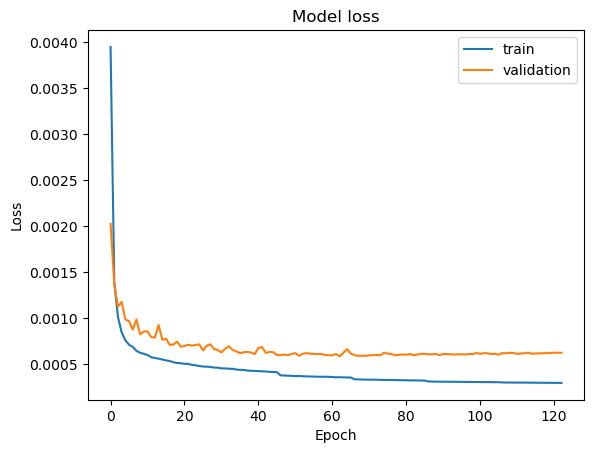

In [17]:
# Visualiser l'évolution de la fonction de coût sur les données d'entraînement et de validation
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
y_pred = model.predict(X_test)

895/895 [==============================] - 11s 11ms/step


In [19]:
# Calculer les indicateurs de performance
rmse =  []
mae  =  []
mse  =  []
r2   =  []

for i in range(horizon):
    rmse.append(np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i])))
    mae.append(mean_absolute_error(y_test[:, i], y_pred[:, i]))
    mse.append(mean_squared_error(y_test[:, i], y_pred[:, i]))
    r2.append(r2_score(y_test[:, i], y_pred[:, i]))
# Afficher les indicateurs de performance
print('RMSE:', rmse)

RMSE: [0.014939157525375389, 0.02030911868064931, 0.025245350160153928, 0.029039233427446513, 0.03265217642981191, 0.03589588687543568]


In [20]:
pred = y_pred[::horizon, :]
pred = pred.reshape(-1, 1)
pred.shape

(28638, 1)

In [21]:
test = y_test[::horizon, :]
test = test.reshape(-1, 1)
test.shape

(28638, 1)

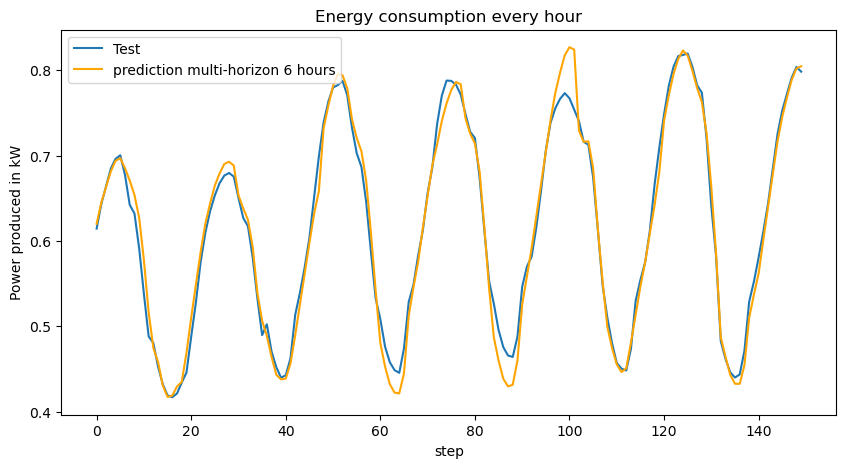

In [48]:
plt.figure(figsize=(10, 5))

start = 0
end = 150
plt.plot(np.arange(start, end, 1), test[start:end], label="Test")
plt.plot(np.arange(start, end, 1), pred[start:end], c="orange", label="prediction multi-horizon 6 hours")
plt.xlabel("step")
plt.ylabel("Power produced in kW")
plt.title("Energy consumption every hour")
plt.legend()